In [1]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
# importing some awesome libraries
import os
import cv2
import time
import copy
import torch
import shap
import random 
import torchvision
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.autograd import Variable
from torch.utils.data import ConcatDataset
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms

sns.set()

In [3]:
# function to train model
def train_model(model, criterion, optimizer, num_epochs):
    cnt = 0
    since = time.time() # Marking start-time
    best_model = copy.deepcopy(model.state_dict()) # Yet to figure-out
    best_acc = 0.0 # Starting Accuracy of the model
    
    for epoch in range(num_epochs): 
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        
        # train
        # model.train() tells your model that you are training the model. This helps inform layers such as Dropout and BatchNorm,
        # which are designed to behave differently during training and evaluation. For instance, in training mode,
        # BatchNorm updates a moving average on each new batch; whereas, for evaluation mode, these updates are frozen.
        
        model.train()
        
        # More details: model.train() sets the mode to train (see source code).
        # You can call either model.eval() or model.train(mode=False) to tell that you are testing.
        # It is somewhat intuitive to expect train function to train model but it does not do that. It just sets the mode.
        
        
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader: # Train 1 Batch (32 Images) at a Time
            # Tensors to(device)            # Each epoch evaluates on 164 total batches, meaning train-loader passes 164 batches of 32 images each to train in 1 epoch
            """
            # tensor a is in CPU
            device = torch.device('cuda:0')
            b = a.to(device)
            # a is still in CPU!
            # b is in GPU!
            # a and b are different 
            """
            
            # Models to(device)
            """
            # model a is in CPU
            device = torch.device('cuda:0')
            b = a.to(device)
            # a and b are in GPU
            # a and b point to the same model 
            """
            inputs = inputs.to(device) # Sending Inputs Tensor to GPU
            labels = labels.to(device) # Sending Labels Tensor to GPU
            
            optimizer.zero_grad() # Zero-out previous Accumulated Gradients during the backward stage     
                        
            with torch.set_grad_enabled(True): # Sets Gradient calculation to True
                outputs = model(inputs) # Model predicts
                """
                >>> a = torch.randn(4, 4)
                >>> a
                tensor([[-1.2360, -0.2942, -0.1222,  0.8475],
                        [ 1.1949, -1.1127, -2.2379, -0.6702],
                        [ 1.5717, -0.9207,  0.1297, -1.8768],
                        [-0.6172,  1.0036, -0.6060, -0.2432]])
                >>> torch.max(a, 1)
                torch.return_types.max(values=tensor([0.8475, 1.1949, 1.5717, 1.0036]), indices=tensor([3, 0, 0, 1]))
                """
                _, preds = torch.max(outputs, 1) # Returns an Output Tensor with max value: unknown(assigned to _) and the indices (assigned to preds) 
                # print(_) 
                # print(preds)
                # print(outputs)
                # break
                loss = criterion(outputs, labels) # Calculating CrossEntropyLoss
                loss.backward() # Gradient Accumulation happens here (Understand why we can't use BCE for calculating the loss)
                optimizer.step() # Weights are updated in this step
            running_loss += loss.item() * inputs.size(0) # Loss accumulated for each batch pass (1) is stored in the running loss variable
            running_corrects += torch.sum(preds == labels.data) # Number of correctly classified instances are stored here for each batch
            cnt = cnt + 1
        print(cnt)
        epoch_loss = running_loss / train_size # Overall loss for 1 epoch (164 batches) is calculated here
        epoch_acc = running_corrects.double() / train_size # Training accuracy is calculated here
        print('Train Loss: {:.4f} Train Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        
        # validate
        model.eval() # Model Evaluation Stage
        running_loss = 0.0 # declaring running loss for validation set
        running_corrects = 0 # declaring running corrects for validation set
        for inputs, labels in val_loader: # validation set - 1 Batch (32 Images) at a Time
            inputs = inputs.to(device) # Sending the tensor image to GPU
            labels = labels.to(device) # Sending Label tensors to GPU
            optimizer.zero_grad() # Zero-out previous Accumulated Gradients during the backward stage   
            with torch.set_grad_enabled(False): # Sets Gradient calculation to False
                outputs = model(inputs) # Predicting the output of model
                _, preds = torch.max(outputs, 1) # Returns an Output Tensor with max value: unknown(assigned to _) and the indices (assigned to preds) 
                loss = criterion(outputs, labels) # Estimating the loss
            running_loss += loss.item() * inputs.size(0) # calculating loss over each batch of validation set
            running_corrects += torch.sum(preds == labels.data) # Calculating correctly classified examples
        epoch_loss = running_loss / val_size # Calculating the overall loss on all the batches of validation set
        epoch_acc = running_corrects.double() / val_size #Calculating the overall correctly classified images in the overall validation set
        print('Val Loss: {:.4f} Val Acc: {:.4f}'.format(epoch_loss, epoch_acc)) # Print iteration loss and accuracy for the overall validation set
        print('-' * 30)
        if epoch_acc > best_acc: # Finding the best model out of all the iterations
            best_acc = epoch_acc
            best_model = copy.deepcopy(model.state_dict())
        
    time_elapsed = time.time() - since # Endtime note
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) # Print time
    print('Best Val Acc: {:.4f}'.format(best_acc)) 
    model.load_state_dict(best_model)# Loading the best model
    return model # return model with best accuracy


# function to predict images and display the accuracy
def visualize_predictions(model, dataset):
    labels = []
    predictions = []
    acc = 0
    was_training = model.training
    model.eval()
    print(len(dataset))
    with torch.no_grad():
        for i in range(len(dataset)):
            input, label = dataset[i]
            input = input[np.newaxis,:]
            input = input.to(device)
            output = model(input)
            _, preds = torch.max(output, 1)
            if class_names[label] == class_names[preds]:
                acc += 1
            labels.append(class_names[label])
            predictions.append(class_names[preds])
    print('Test Accuracy: {:.4f}'.format(acc/len(dataset)))
    model.train(mode=was_training)
    return labels, predictions

In [4]:
# creates a second transforms sequence for the train set
transf_train = transforms.Compose([
    transforms.Resize(57),
    transforms.RandomRotation(10),
    transforms.RandomCrop(54),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# creates the transforms sequence for the test and val sets
transf_test = transforms.Compose([
    transforms.Resize(54),
    transforms.CenterCrop(54),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

# loads the images and applies the transformations
train_set = torchvision.datasets.ImageFolder('../input/chest-xray-pneumonia/chest_xray/train', transform = transf_train)
test_set = torchvision.datasets.ImageFolder('../input/chest-xray-pneumonia/chest_xray/test', transform = transf_test)
val_set = torchvision.datasets.ImageFolder('../input/chest-xray-pneumonia/chest_xray/val', transform = transf_test)

# number of images in each set
train_size = len(train_set)
test_size = len(test_set)
val_size = len(val_set)
print('Train: {} images, Test: {} images, Validation: {} images'.format(train_size, test_size, val_size))

Train: 5216 images, Test: 624 images, Validation: 16 images


In [5]:
normal_dir = '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/'
pneumonia_dir = '../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/'

Nimages = os.listdir(normal_dir)
Pimages = os.listdir(pneumonia_dir)

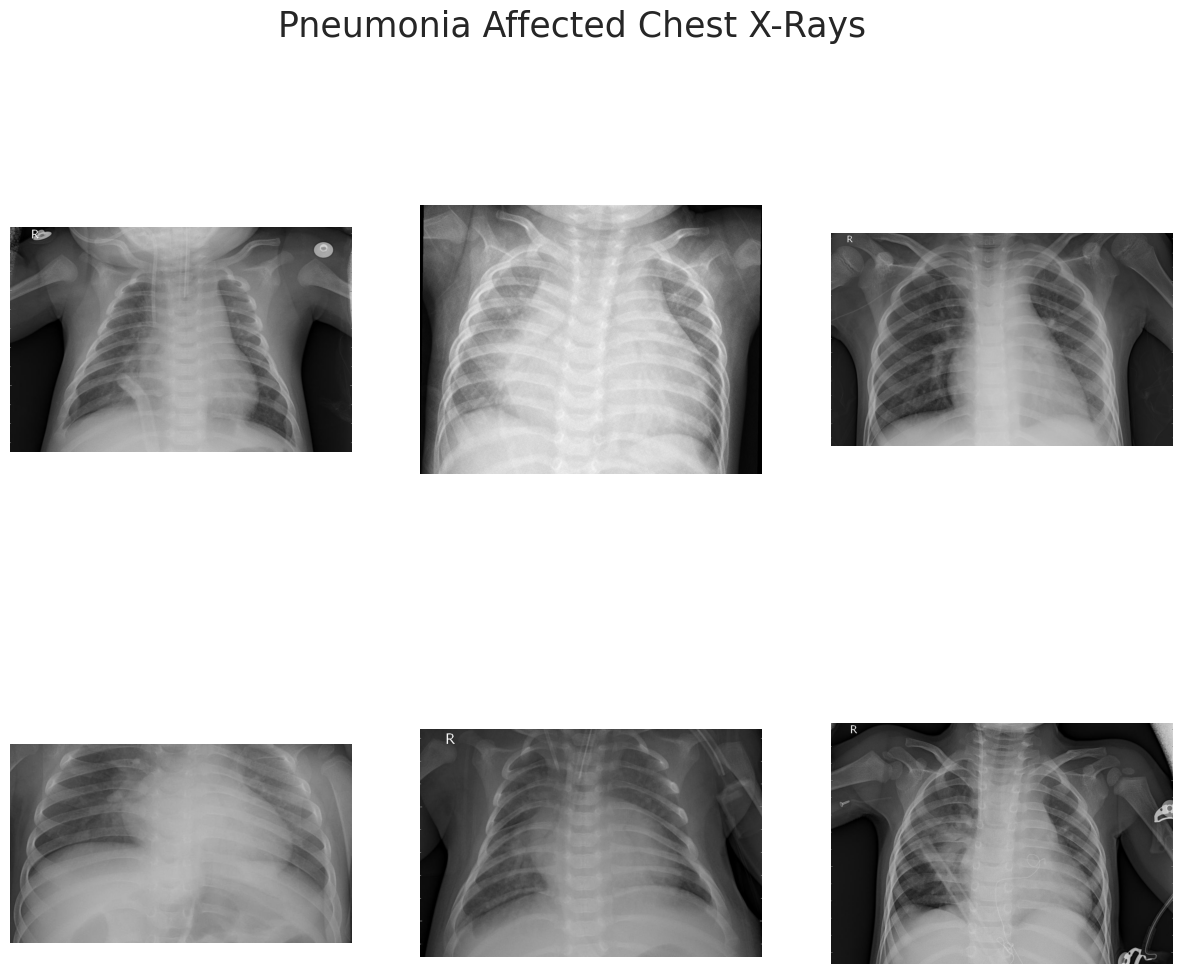

In [6]:
sample_images = random.sample(Pimages,6)
f,ax = plt.subplots(2,3,figsize=(15,12))

for i in range(0,6):
    im = cv2.imread(pneumonia_dir + sample_images[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Pneumonia Affected Chest X-Rays',fontsize=25)
plt.show()

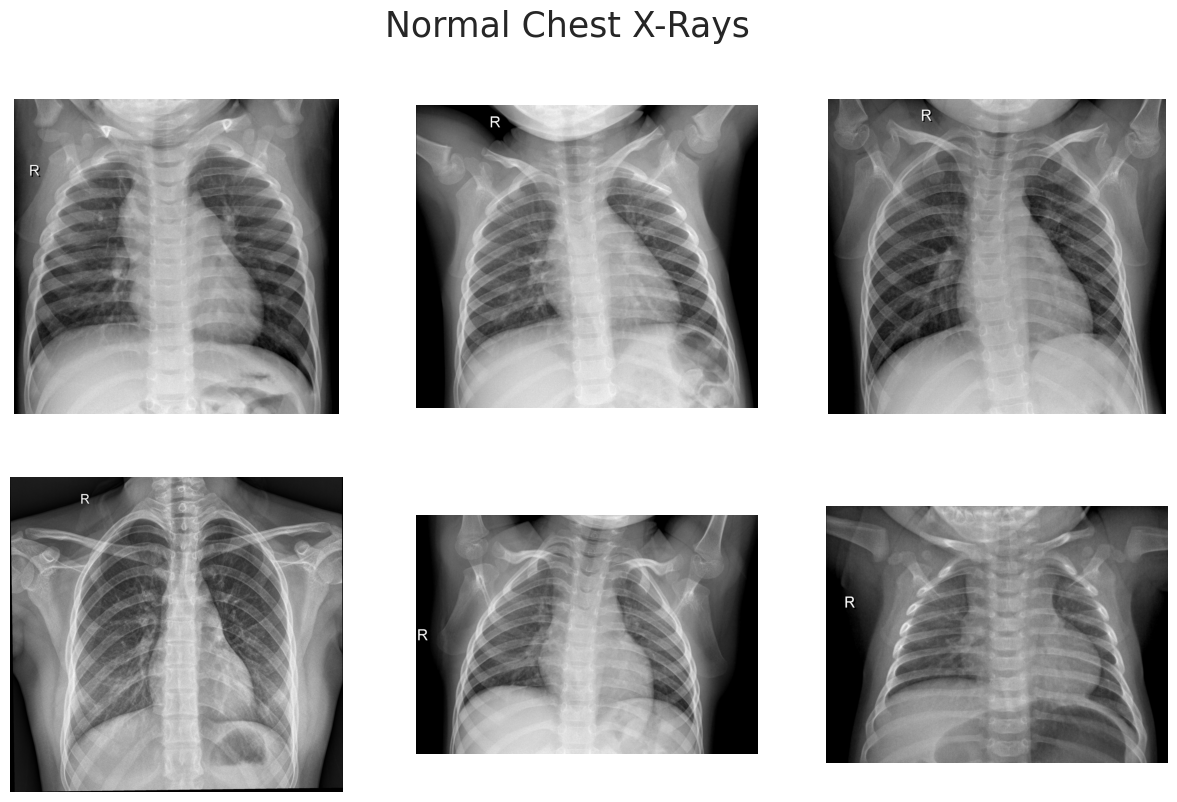

In [7]:
sample_images = random.sample(Nimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread(normal_dir + sample_images[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Normal Chest X-Rays',fontsize=25)
plt.show()

In [8]:
class_names = train_set.classes

train_set, val_set = train_test_split(train_set, test_size=0.2)

train_size = len(train_set)
val_size = len(val_set)

In [9]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle = True, num_workers = 2) # Creates batches of 32 images and labels for training (Total 164 batches made)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = 32, shuffle = True, num_workers = 2) 

In [10]:
# import pretrained model
model = torchvision.models.resnet50(pretrained = True)

# number of features in the input of the linear layer
num_ftrs = model.fc.in_features

# sets the number of features of the linear layer
model.fc = torch.nn.Linear(num_ftrs, len(class_names))

# parameters
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# model summary
summary(model, (3, 50, 50), 16)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 64, 25, 25]           9,408
       BatchNorm2d-2           [16, 64, 25, 25]             128
              ReLU-3           [16, 64, 25, 25]               0
         MaxPool2d-4           [16, 64, 13, 13]               0
            Conv2d-5           [16, 64, 13, 13]           4,096
       BatchNorm2d-6           [16, 64, 13, 13]             128
              ReLU-7           [16, 64, 13, 13]               0
            Conv2d-8           [16, 64, 13, 13]          36,864
       BatchNorm2d-9           [16, 64, 13, 13]             128
             ReLU-10           [16, 64, 13, 13]               0
           Conv2d-11          [16, 256, 13, 13]          16,384
      BatchNorm2d-12          [16, 256, 13, 13]             512
           Conv2d-13          [16, 256, 13, 13]          16,384
      BatchNorm2d-14          [16, 256,

In [11]:
# train the model
model = train_model(model, criterion, optimizer, num_epochs)
# Each Epoch is evaluated on 164 Batches

Epoch 1/10
131
Train Loss: 0.1979 Train Acc: 0.9302
Val Loss: 0.1002 Val Acc: 0.9626
------------------------------
Epoch 2/10
262
Train Loss: 0.0900 Train Acc: 0.9667
Val Loss: 0.1191 Val Acc: 0.9655
------------------------------
Epoch 3/10
393
Train Loss: 0.0762 Train Acc: 0.9715
Val Loss: 0.1407 Val Acc: 0.9397
------------------------------
Epoch 4/10
524
Train Loss: 0.0577 Train Acc: 0.9806
Val Loss: 0.4759 Val Acc: 0.8123
------------------------------
Epoch 5/10
655
Train Loss: 0.1907 Train Acc: 0.9367
Val Loss: 0.0975 Val Acc: 0.9617
------------------------------
Epoch 6/10
786
Train Loss: 0.0903 Train Acc: 0.9676
Val Loss: 0.0971 Val Acc: 0.9617
------------------------------
Epoch 7/10
917
Train Loss: 0.0696 Train Acc: 0.9732
Val Loss: 0.0843 Val Acc: 0.9703
------------------------------
Epoch 8/10
1048
Train Loss: 0.0476 Train Acc: 0.9803
Val Loss: 0.1280 Val Acc: 0.9579
------------------------------
Epoch 9/10
1179
Train Loss: 0.0438 Train Acc: 0.9849
Val Loss: 0.1175 V

# Model Evaluation

In [12]:
# predicting the test set
labels, predictions = visualize_predictions(model, test_set)

624
Test Accuracy: 0.8878


<Figure size 640x480 with 0 Axes>

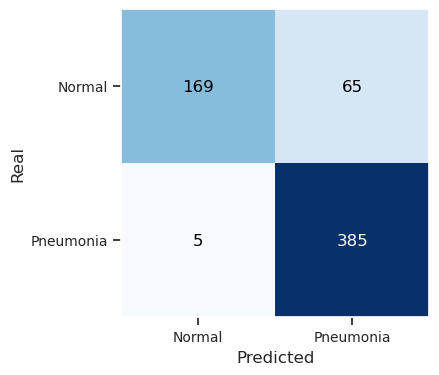

In [13]:
# confusion matrix
matrix = confusion_matrix(labels, predictions)
plt.figure()
plot_confusion_matrix(matrix, figsize=(4,4))
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=10)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.show()

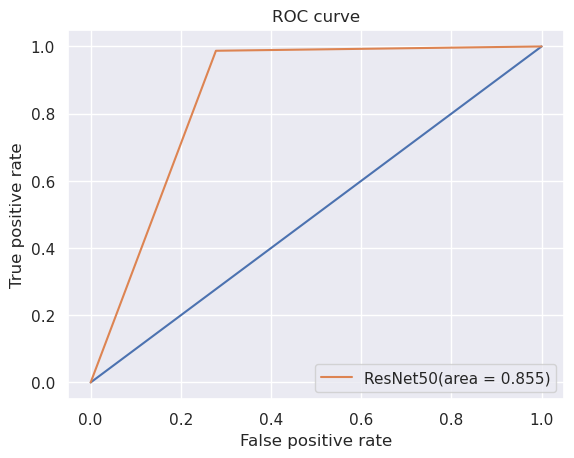

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(labels)

y_true = lb.transform(labels)
y_pred = lb.transform(predictions)

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

plt.figure(1)
plt.plot([0, 1], [0, 1], '-')
plt.plot(fpr, tpr, label='ResNet50(area = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [15]:
test_data_loader = torch.utils.data.DataLoader(test_set, batch_size = 8, shuffle = True, num_workers = 2) 

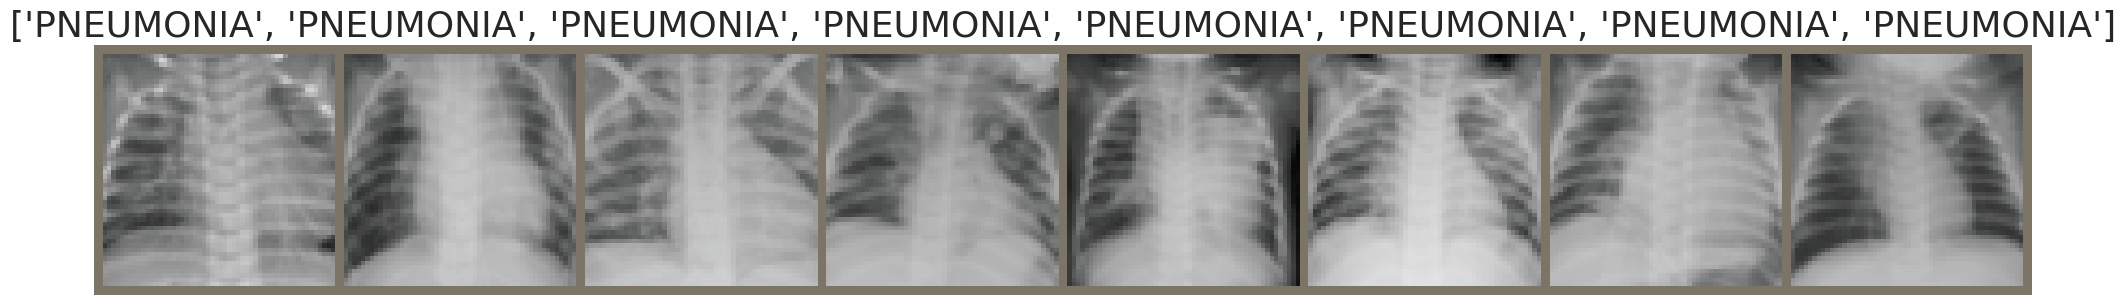

In [16]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(25, 25))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=26)
    plt.pause(0.001)
    
def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(test_data_loader))
show_databatch(inputs, classes)

In [17]:
def visualize_model(model, num_images=6):
    was_training = model.training
    
    # Set model for evaluation
    model.train(False)
    model.eval() 
    
    images_so_far = 0

    for _, data in enumerate(test_data_loader):
        inputs, labels = data
        size = inputs.size()[0]
        
        inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        
        outputs = model(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    model.train(mode=was_training) # Revert model back to original training state

volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Ground truth:


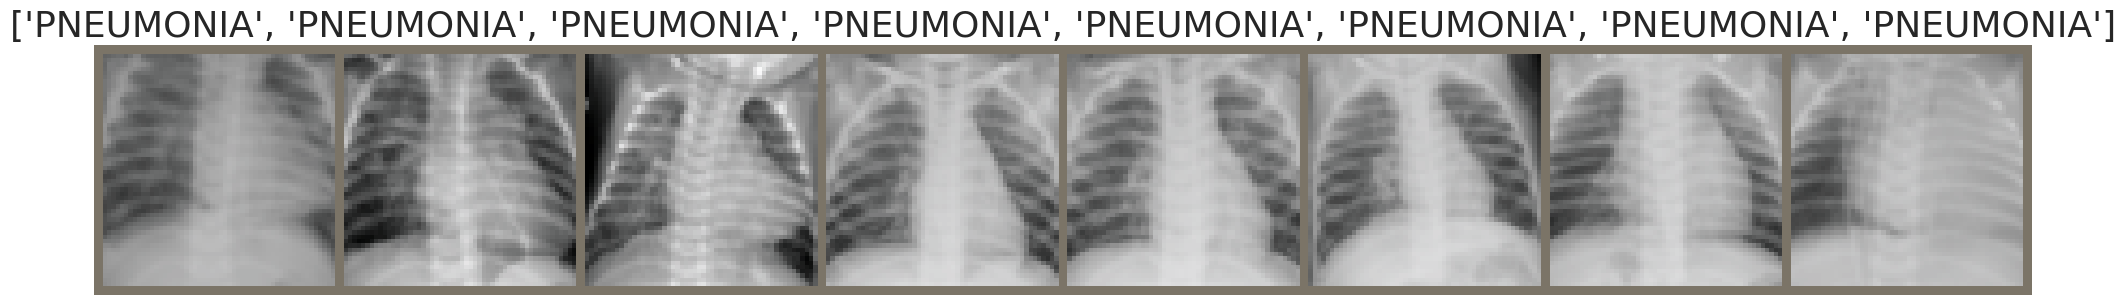

Prediction:


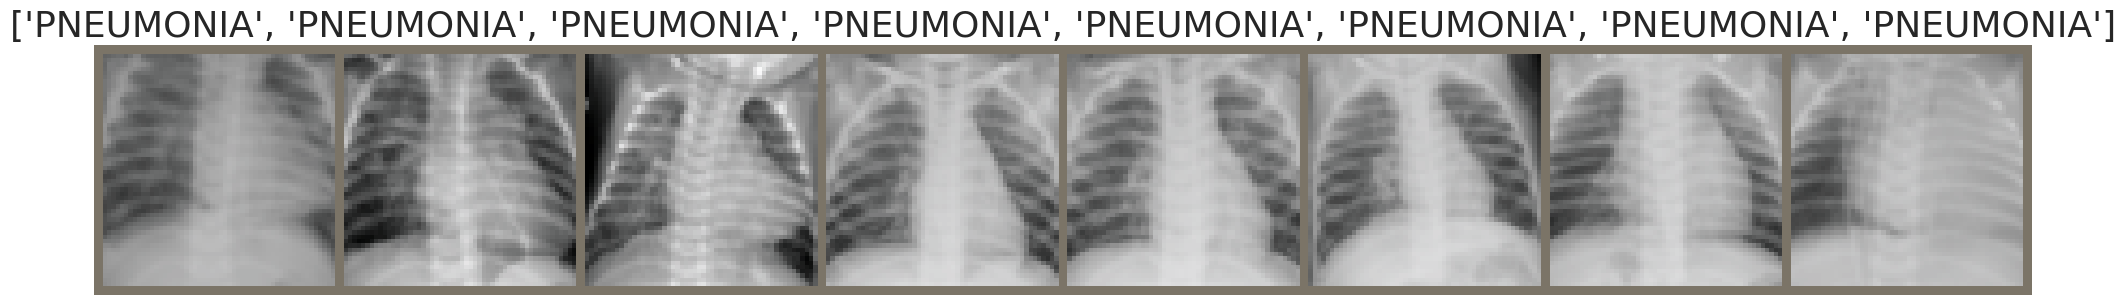

Ground truth:


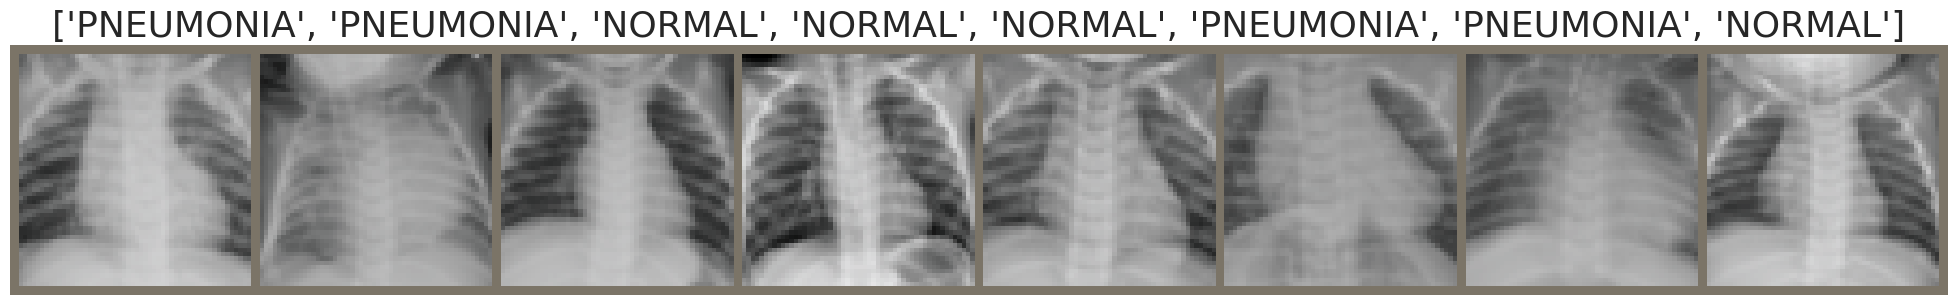

Prediction:


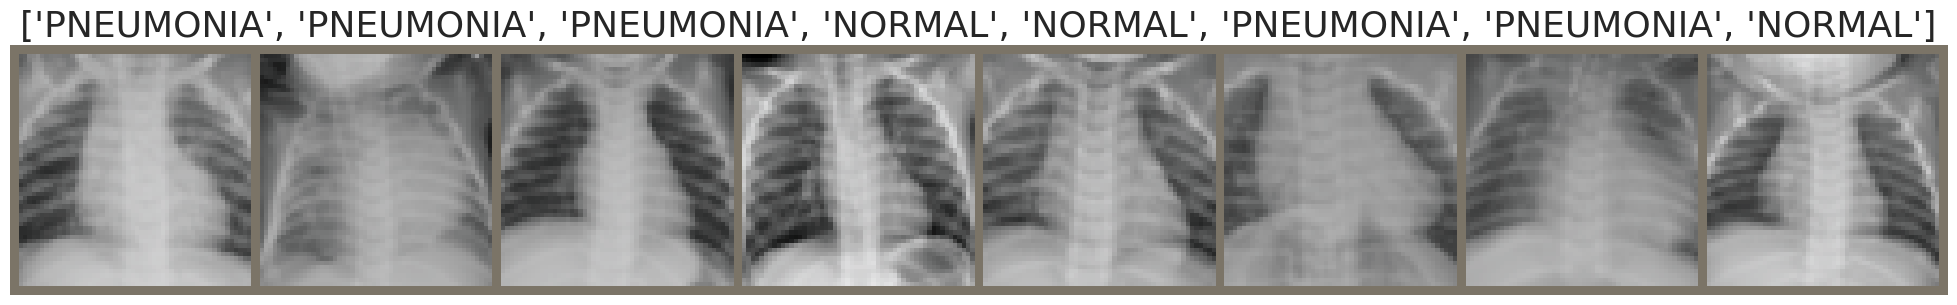

Ground truth:


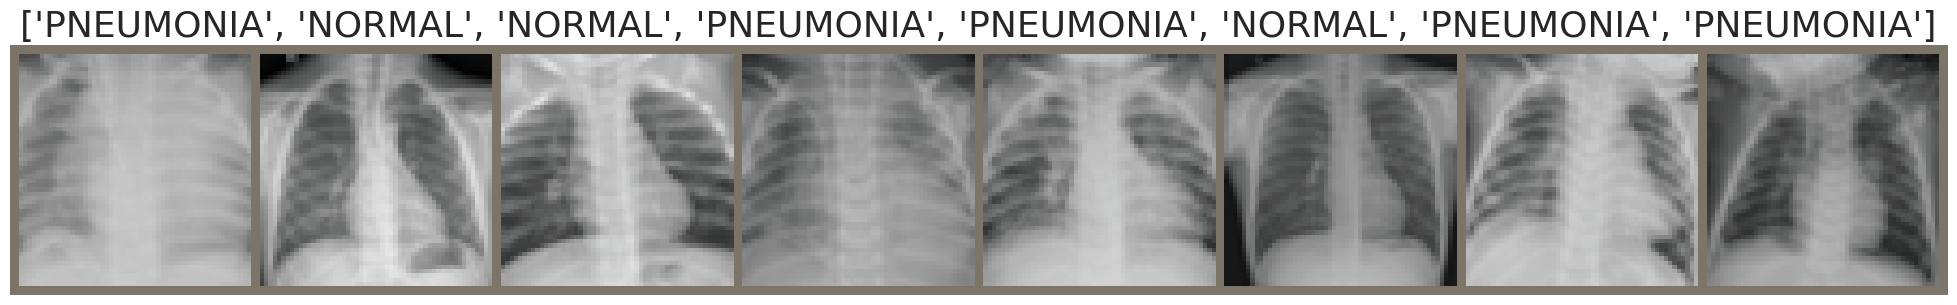

Prediction:


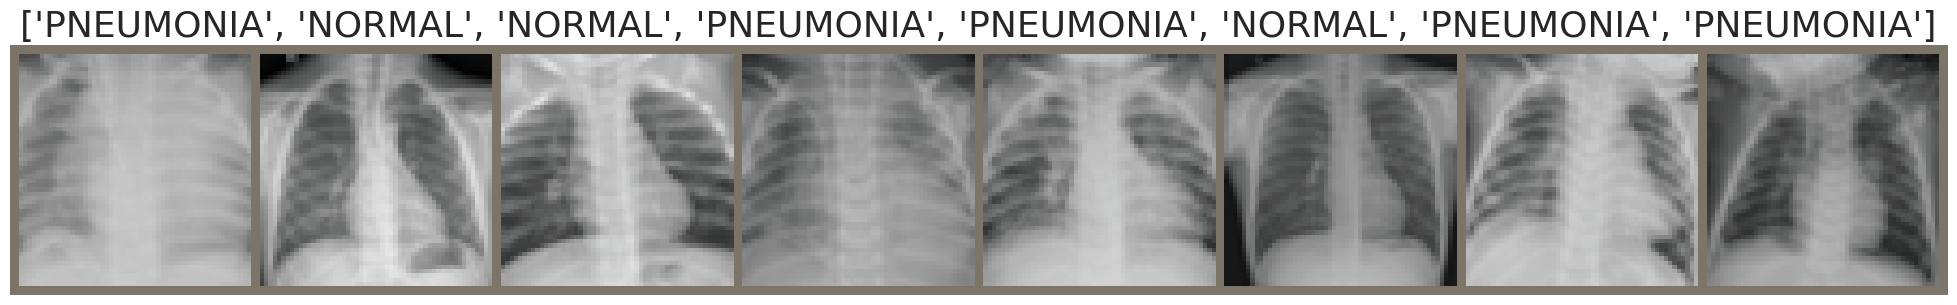

Ground truth:


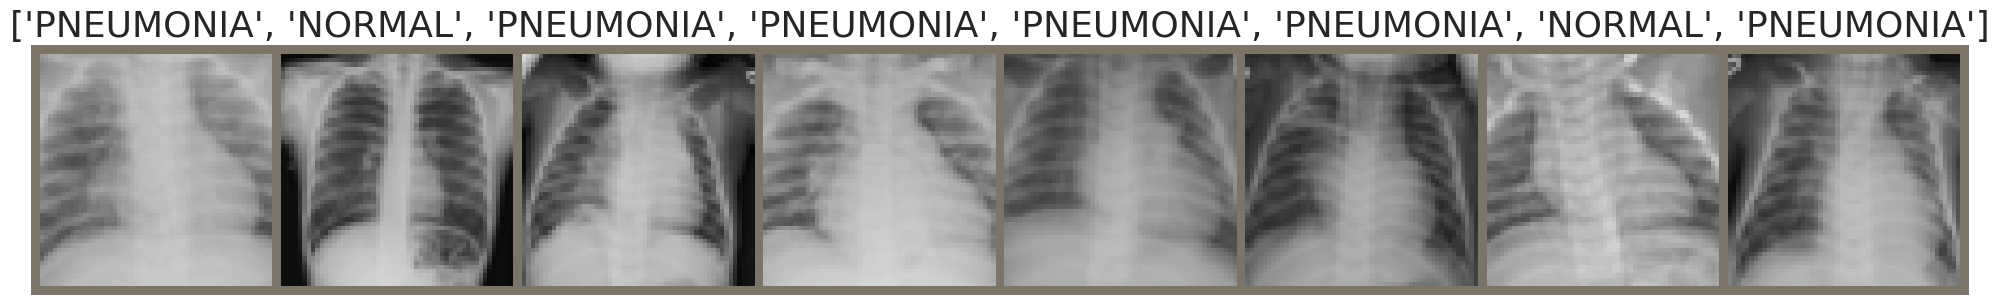

Prediction:


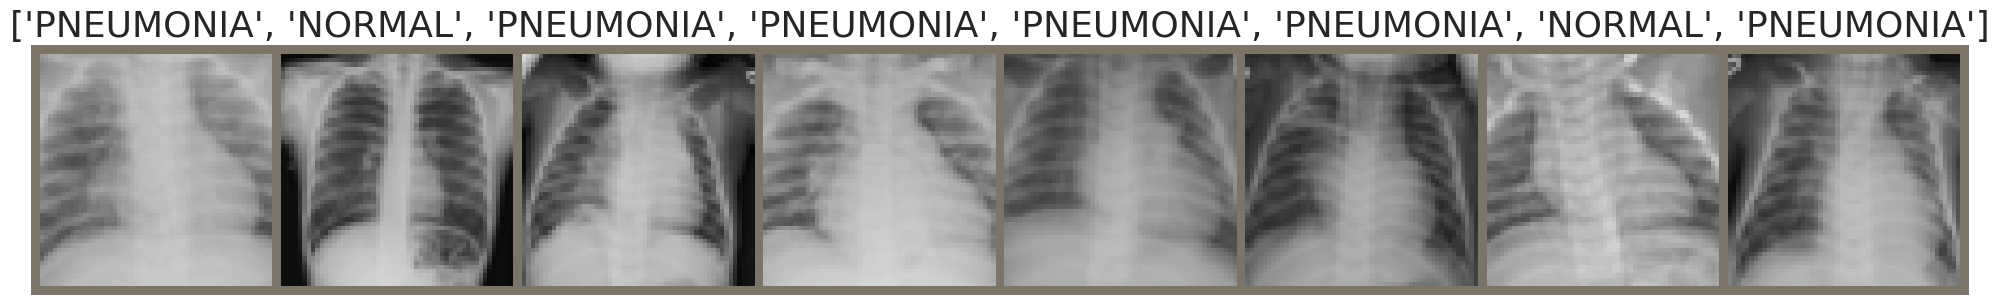

In [18]:
visualize_model(model, num_images=32)